## Train Deep Learning Models

In this notebook, we train a set of deep learning models using data generated in the dataset_generation notebook. The input training data for each model is the audio features extracted for a synth patch, and the ground truth data is the parameter values for that synth patch. Each trained model is saved in the saved_models folder.

In [1]:
import spiegelib as spgl
import numpy as np
import tensorflow as tf

#### Multi-Layer Perceptron

Her we train a relatively basic fully connected MLP model. The audio features, which are in numpy arrays with time slices, need to be flattened prior to being fed into the network.

In [2]:
trainFeatures = np.load('./data_simple_FM_mfcc/train_features.npy')
trainParams = np.load('./data_simple_FM_mfcc/train_patches.npy')
testFeatures = np.load('./data_simple_FM_mfcc/test_features.npy')
testParams = np.load('./data_simple_FM_mfcc/test_patches.npy')

# Flatten feature time slices
trainFeatures = trainFeatures.reshape(trainFeatures.shape[0], -1)
testFeatures = testFeatures.reshape(testFeatures.shape[0], -1)

# Setup callbacks for trainings
logger = spgl.estimator.TFEpochLogger()
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Instantiate MLP Model
mlp = spgl.estimator.MLP((trainFeatures.shape[-1],),
                            trainParams.shape[-1],
                            callbacks=[logger, earlyStopping])

# Add training and validation data
mlp.add_training_data(trainFeatures, trainParams)
mlp.add_testing_data(testFeatures, testParams)
mlp.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                28650     
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 279       
Total params: 32,199
Trainable params: 32,199
Non-trainable params: 0
_________________________________________________________________


In [3]:
mlp.fit(epochs=100)

Train for 782 steps, validate for 157 steps
Epoch 1/100
782/782 [==============================] - 2s 2ms/step - loss: 0.2686 - accuracy: 0.2484 - val_loss: 0.2542 - val_accuracy: 0.2744
Epoch 2/100
782/782 [==============================] - 1s 2ms/step - loss: 0.2511 - accuracy: 0.2770 - val_loss: 0.2508 - val_accuracy: 0.2877
Epoch 3/100
782/782 [==============================] - 1s 2ms/step - loss: 0.2480 - accuracy: 0.2896 - val_loss: 0.2481 - val_accuracy: 0.2973
Epoch 4/100
782/782 [==============================] - 1s 2ms/step - loss: 0.2457 - accuracy: 0.3006 - val_loss: 0.2472 - val_accuracy: 0.3000
Epoch 5/100
782/782 [==============================] - 1s 2ms/step - loss: 0.2439 - accuracy: 0.3100 - val_loss: 0.2469 - val_accuracy: 0.3084
Epoch 6/100
782/782 [==============================] - 1s 2ms/step - loss: 0.2425 - accuracy: 0.3129 - val_loss: 0.2450 - val_accuracy: 0.3117
Epoch 7/100
782/782 [==============================] - 1s 2ms/step - loss: 0.2414 - accuracy: 0.31

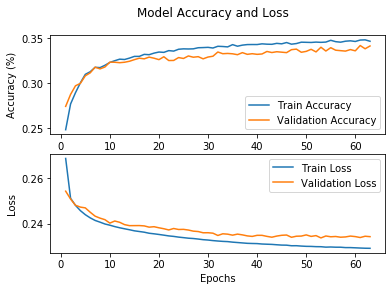

In [4]:
mlp.save_model('./saved_models/simple_fm_mlp.h5')
logger.plot()

#### Long short-term memory (LSTM) 

In [5]:
trainFeatures = np.load('./data_simple_FM_mfcc/train_features.npy')
trainParams = np.load('./data_simple_FM_mfcc/train_patches.npy')
testFeatures = np.load('./data_simple_FM_mfcc/test_features.npy')
testParams = np.load('./data_simple_FM_mfcc/test_patches.npy')

# Setup callbacks for trainings
logger = spgl.estimator.TFEpochLogger()
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

lstm = spgl.estimator.LSTM(trainFeatures.shape[-2:],
                              trainParams.shape[-1],
                              callbacks=[logger, earlyStopping])

lstm.add_training_data(trainFeatures, trainParams)
lstm.add_testing_data(testFeatures, testParams)
lstm.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 44, 100)           45600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 44, 100)           80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 909       
Total params: 207,309
Trainable params: 207,309
Non-trainable params: 0
_________________________________________________________________


In [6]:
lstm.fit(epochs=100)

Train for 782 steps, validate for 157 steps
Epoch 1/100
782/782 [==============================] - 81s 104ms/step - loss: 0.2666 - accuracy: 0.2356 - val_loss: 0.2522 - val_accuracy: 0.2579
Epoch 2/100
782/782 [==============================] - 76s 97ms/step - loss: 0.2538 - accuracy: 0.2575 - val_loss: 0.2499 - val_accuracy: 0.2771
Epoch 3/100
782/782 [==============================] - 76s 97ms/step - loss: 0.2499 - accuracy: 0.2742 - val_loss: 0.2461 - val_accuracy: 0.2839
Epoch 4/100
782/782 [==============================] - 76s 97ms/step - loss: 0.2460 - accuracy: 0.2870 - val_loss: 0.2411 - val_accuracy: 0.3079
Epoch 5/100
782/782 [==============================] - 76s 97ms/step - loss: 0.2412 - accuracy: 0.3128 - val_loss: 0.2369 - val_accuracy: 0.3272
Epoch 6/100
782/782 [==============================] - 76s 97ms/step - loss: 0.2379 - accuracy: 0.3284 - val_loss: 0.2344 - val_accuracy: 0.3392
Epoch 7/100
782/782 [==============================] - 79s 100ms/step - loss: 0.2357 

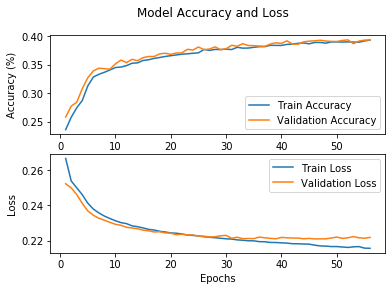

In [7]:
lstm.save_model('./saved_models/simple_fm_lstm.h5')
logger.plot()

#### Bi-directional long short-term memory with highway layers (LSTM++)

In [8]:
# Setup callbacks for trainings
logger = spgl.estimator.TFEpochLogger()
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

bi_lstm = spgl.estimator.HwyBLSTM(trainFeatures.shape[-2:],
                                     trainParams.shape[-1],
                                     callbacks=[logger, earlyStopping],
                                     highway_layers=6)

bi_lstm.add_training_data(trainFeatures, trainParams)
bi_lstm.add_testing_data(testFeatures, testParams)
bi_lstm.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 256)               145408    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
highway_layer (HighwayLayer) (None, 64)                8320      
_________________________________________________________________
highway_layer_1 (HighwayLaye (None, 64)                8320      
_________________________________________________________________
highway_layer_2 (HighwayLaye (None, 64)                8320      
_________________________________________________________________
highway_layer_3 (HighwayLaye (None, 64)               

In [9]:
bi_lstm.fit(epochs=100)

Train for 782 steps, validate for 157 steps
Epoch 1/100
782/782 [==============================] - 47s 61ms/step - loss: 0.2767 - accuracy: 0.2258 - val_loss: 0.2541 - val_accuracy: 0.2645
Epoch 2/100
782/782 [==============================] - 44s 56ms/step - loss: 0.2535 - accuracy: 0.2742 - val_loss: 0.2490 - val_accuracy: 0.2993
Epoch 3/100
782/782 [==============================] - 44s 56ms/step - loss: 0.2490 - accuracy: 0.2955 - val_loss: 0.2463 - val_accuracy: 0.3013
Epoch 4/100
782/782 [==============================] - 44s 56ms/step - loss: 0.2465 - accuracy: 0.3036 - val_loss: 0.2426 - val_accuracy: 0.3232
Epoch 5/100
782/782 [==============================] - 44s 56ms/step - loss: 0.2437 - accuracy: 0.3157 - val_loss: 0.2404 - val_accuracy: 0.3241
Epoch 6/100
782/782 [==============================] - 45s 58ms/step - loss: 0.2415 - accuracy: 0.3207 - val_loss: 0.2385 - val_accuracy: 0.3271
Epoch 7/100
782/782 [==============================] - 45s 57ms/step - loss: 0.2395 - 

Epoch 57/100
782/782 [==============================] - 43s 55ms/step - loss: 0.2204 - accuracy: 0.3871 - val_loss: 0.2238 - val_accuracy: 0.3884
Epoch 58/100
782/782 [==============================] - 43s 54ms/step - loss: 0.2201 - accuracy: 0.3849 - val_loss: 0.2238 - val_accuracy: 0.3842
Epoch 59/100
782/782 [==============================] - 42s 53ms/step - loss: 0.2198 - accuracy: 0.3881 - val_loss: 0.2242 - val_accuracy: 0.3842
Epoch 60/100
782/782 [==============================] - 42s 53ms/step - loss: 0.2198 - accuracy: 0.3887 - val_loss: 0.2240 - val_accuracy: 0.3864
Epoch 61/100
782/782 [==============================] - 41s 53ms/step - loss: 0.2197 - accuracy: 0.3882 - val_loss: 0.2239 - val_accuracy: 0.3837
Epoch 62/100
782/782 [==============================] - 41s 53ms/step - loss: 0.2196 - accuracy: 0.3860 - val_loss: 0.2239 - val_accuracy: 0.3862
Epoch 63/100
782/782 [==============================] - 41s 53ms/step - loss: 0.2195 - accuracy: 0.3879 - val_loss: 0.2240 -

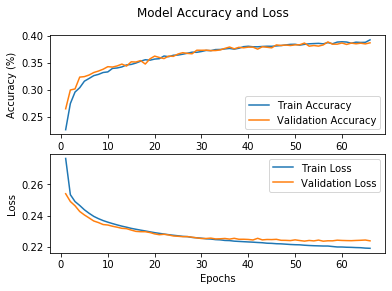

In [10]:
bi_lstm.save_model('./saved_models/simple_fm_bi_lstm.h5')
logger.plot()

#### Convolutional Neural Network (CNN)

In [11]:
trainFeatures = np.load('./data_simple_FM_stft/train_features.npy')
trainParams = np.load('./data_simple_FM_stft/train_patches.npy')
testFeatures = np.load('./data_simple_FM_stft/test_features.npy')
testParams = np.load('./data_simple_FM_stft/test_patches.npy')    

# Create "STFT Images" with one channel for 2D CNN
trainFeatures = trainFeatures.reshape(trainFeatures.shape[0], trainFeatures.shape[1], trainFeatures.shape[2], 1)
testFeatures = testFeatures.reshape(testFeatures.shape[0], testFeatures.shape[1], testFeatures.shape[2], 1)

In [12]:
# Setup callbacks for trainings
logger = spgl.estimator.TFEpochLogger()
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

cnn = spgl.estimator.Conv6(trainFeatures.shape[1:],
                              trainParams.shape[-1],
                              callbacks=[logger, earlyStopping])

cnn.add_training_data(trainFeatures, trainParams)
cnn.add_testing_data(testFeatures, testParams)
cnn.model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 87, 128, 32)       320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 63, 71)        20519     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 20, 128)       109184    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 9, 128)        147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)         147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 1, 128)         147584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 1, 128)        

In [13]:
cnn.fit(epochs=100)

Train for 782 steps, validate for 157 steps
Epoch 1/100
782/782 [==============================] - 366s 468ms/step - loss: 0.2618 - accuracy: 0.2453 - val_loss: 0.2500 - val_accuracy: 0.2611
Epoch 2/100
782/782 [==============================] - 361s 461ms/step - loss: 0.2485 - accuracy: 0.2831 - val_loss: 0.2425 - val_accuracy: 0.2897
Epoch 3/100
782/782 [==============================] - 355s 455ms/step - loss: 0.2442 - accuracy: 0.2934 - val_loss: 0.2411 - val_accuracy: 0.2945
Epoch 4/100
782/782 [==============================] - 360s 460ms/step - loss: 0.2417 - accuracy: 0.3020 - val_loss: 0.2401 - val_accuracy: 0.3001
Epoch 5/100
782/782 [==============================] - 359s 459ms/step - loss: 0.2398 - accuracy: 0.3067 - val_loss: 0.2393 - val_accuracy: 0.2999
Epoch 6/100
782/782 [==============================] - 360s 461ms/step - loss: 0.2384 - accuracy: 0.3120 - val_loss: 0.2393 - val_accuracy: 0.2983
Epoch 7/100
782/782 [==============================] - 357s 456ms/step - l

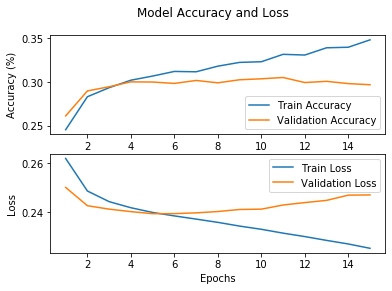

In [14]:
cnn.save_model('./saved_models/simple_fm_cnn.h5')
logger.plot()